In [237]:
import pandas as pd
import numpy as np
import os
import sys
from trimesh import load_mesh
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.ccf_utils import ccf_pts_convert_to_mm
import matplotlib.pyplot as plt
%matplotlib inline

In [238]:
data_dir = '/root/capsule/scratch/combined/retro_ccf/manual_proofread_ccf_18brains.csv'
retro_ccf = pd.read_csv(data_dir)

In [239]:
retro_ccf.groupby(['injection_region']).count()

,brain,channel,x,y,z
injection_region,,,,,
CB,3828,3828,3828,3828,3828
CTX,2714,2714,2714,2714,2714
SP,3177,3177,3177,3177,3177
TH,2211,2211,2211,2211,2211


In [240]:
ml, ap, dv = 0, 2, 1
ml_mesh, ap_mesh, dv_mesh = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
planes_mesh = {'sag': [ap_mesh, dv_mesh], 'hor': [ml_mesh, ap_mesh], 'cor': [ml_mesh, dv_mesh]}

In [241]:
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
mesh_vertices_mm[:, ap_mesh]
ccf_neurons = retro_ccf[['x', 'y', 'z']].values
ccf_neurons = ccf_neurons[:, [2, 1, 0]]
ccf_neurons_mm = ccf_pts_convert_to_mm(ccf_neurons)
ccf_neurons_mm[:, ml_mesh] = -np.abs(ccf_neurons_mm[:, ml_mesh])  # Mirror ML to left
ccf_center = np.mean(ccf_neurons_mm, axis=0)

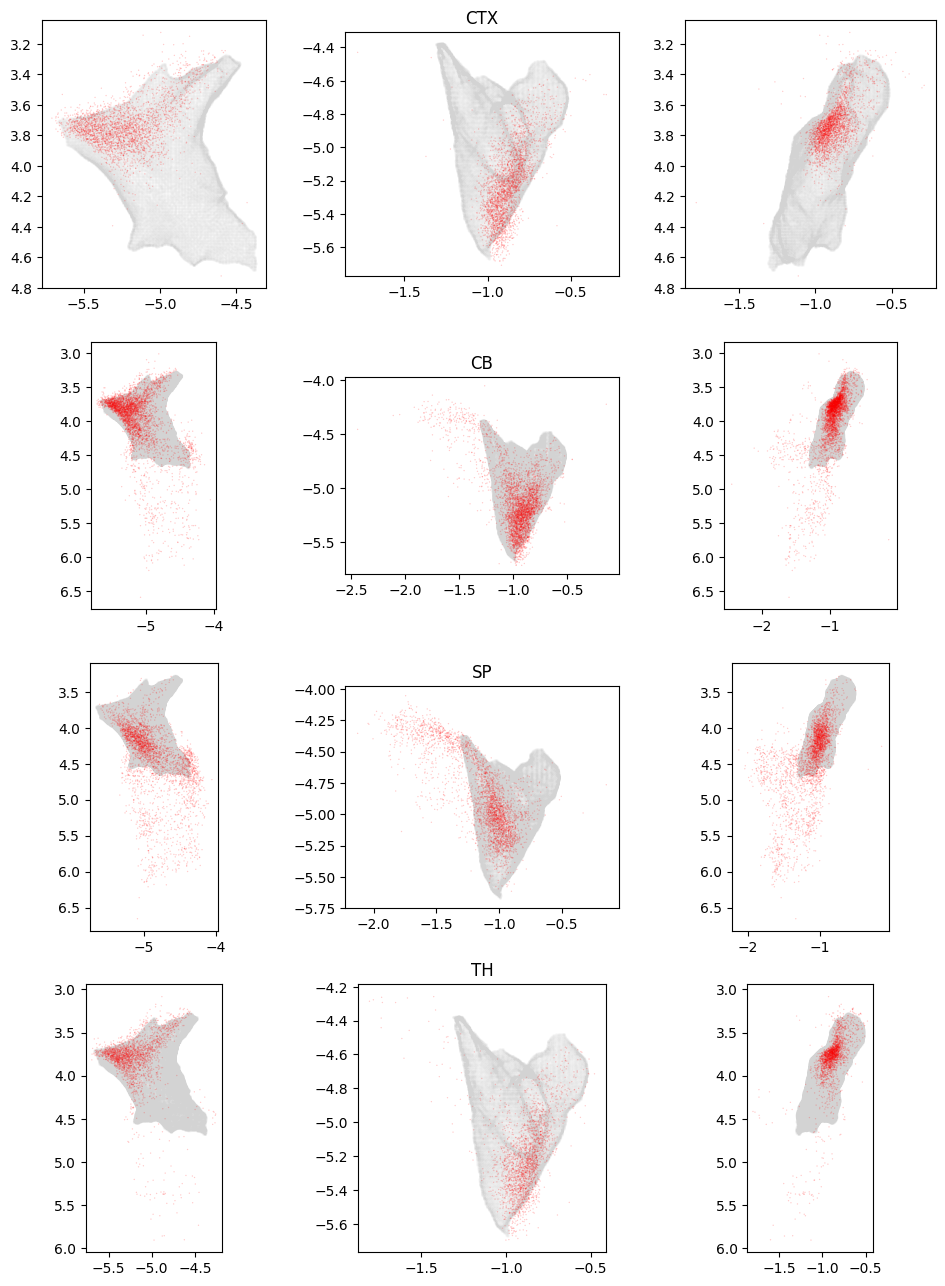

In [242]:
fig = plt.figure(figsize=(12, 4*len(retro_ccf['injection_region'].unique())))
gs = fig.add_gridspec(len(retro_ccf['injection_region'].unique()), 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    # ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        ax = fig.add_subplot(gs[ind, ax_ind])
        ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
        sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color='r', alpha=0.2, s=1, edgecolor='none', label=tar)
        ax.set_aspect(aspect='equal')
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        if plane == 'hor':
            ax.set_title(tar)
    # ax.set_title(plane)

In [243]:
# # Step 1: Extract the relevant data
# coordinates = df_ipsi[['RC', 'DV', 'ML']].values
projection_regions = retro_ccf['injection_region'].values
filter = (projection_regions!="TH") & (ccf_neurons_mm[:, dv_mesh] <= mesh_vertices_mm[:, dv_mesh].max())
# # Step 2: Perform PCA
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(coordinates)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 3: Perform LDA on the PCA result
lda = LinearDiscriminantAnalysis(n_components=2)
lda_result = lda.fit_transform(ccf_neurons_mm[filter], projection_regions[filter])

In [244]:
# change projection regions to numbers
projection_regions_num = np.zeros_like(projection_regions)
for i, region in enumerate(np.unique(projection_regions)):
    projection_regions_num[projection_regions == region] = i

/opt/conda/lib/python3.10/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


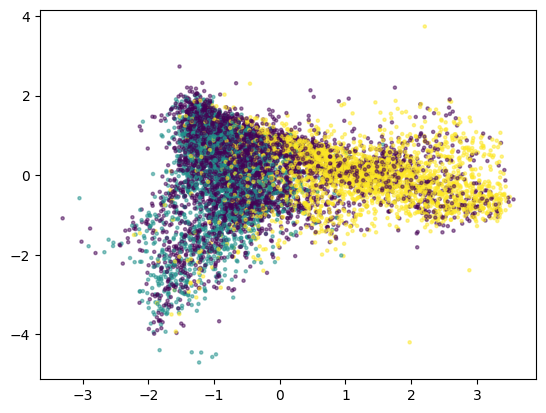

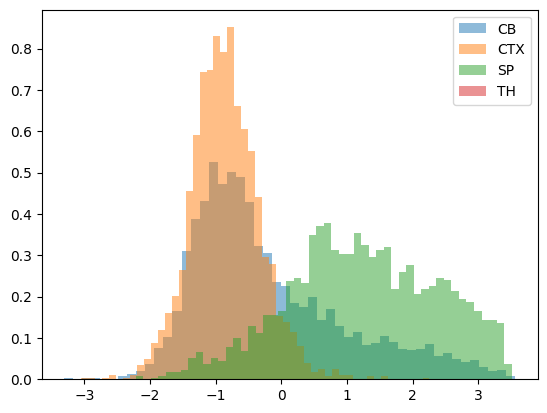

In [245]:
plt.figure()
plt.scatter(lda_result[:, 0], lda_result[:, 1], c=projection_regions_num[filter], cmap='viridis', alpha=0.5, s = 5)
# plt histogram of projection regions along the first LDA axis
plt.figure()
for i, region in enumerate(np.unique(projection_regions)):
    plt.hist(lda_result[projection_regions_num[filter] == i, 0], bins=50, alpha=0.5, label=region, density=True)
plt.legend()

In [246]:
# Step 4: Get the primary axis of variation
# LDA provides a linear discriminant, which can be interpreted as the primary axis of variation
primary_axis_vector = lda.scalings_[:, 0]  # First linear discriminant

# Normalize the vector for better interpretation
primary_axis_vector_LDA = primary_axis_vector / np.linalg.norm(primary_axis_vector)
 
# Display the primary axis of variation
print("Primary axis of variation (in PCA space):", primary_axis_vector_LDA)


Primary axis of variation (in PCA space): [0.2691258  0.95724492 0.10608238]


In [247]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm

# filter = projection_regions != 'TH'
filter = ((projection_regions == 'CTX') | (projection_regions == 'SP')) & (ccf_neurons_mm[:, dv_mesh] <= mesh_vertices_mm[:, dv_mesh].max())
# Assume X is your features and y is binary or multiclass target
ccf_neurons_mm_with_const = sm.add_constant(ccf_neurons_mm)  # Add intercept
projection_regions_bin = projection_regions == 'SP'
# model = sm.MNLogit(projection_regions[filter], ccf_neurons_mm_with_const[filter])  # For multinomial; use sm.Logit for binary
model = sm.Logit(projection_regions_bin[filter], ccf_neurons_mm_with_const[filter]) 
result = model.fit()

# Get 95% confidence intervals
ci = result.conf_int(alpha=0.05)
# ci.columns = ['5%', '95%']

# # MLR

# mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# mlr.fit(ccf_neurons_mm[filter], projection_regions[filter])

# primary_axis_vector_MLR = mlr.coef_  # First linear discriminant
# # Normalize the vector for better interpretation
if len(result.params.shape) > 1:
    primary_axis_vector_MLR = result.params[1:, 0] * np.sign(result.params[2, 0])  # First linear discriminant
else:
    # If only two classes, use the coefficients directly
    primary_axis_vector_MLR = result.params[1:] * np.sign(result.params[2])  # First linear discriminant
primary_axis_vector_MLR = primary_axis_vector_MLR / np.linalg.norm(primary_axis_vector_MLR)
# Display the primary axis of variation
print("Primary axis of variation (in MLR space):", primary_axis_vector_MLR)
result.summary(), ci

Optimization terminated successfully.
         Current function value: 0.254185
         Iterations 8
Primary axis of variation (in MLR space): [ 0.44137469  0.79373018 -0.41854604]


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                      y   No. Observations:                 5140
 Model:                          Logit   Df Residuals:                     5136
 Method:                           MLE   Df Model:                            3
 Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.6325
 Time:                        13:45:59   Log-Likelihood:                -1306.5
 converged:                       True   LL-Null:                       -3554.8
 Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const        -14.5191      2.108     -6.888      0.000     -18.651     -10.388
 x1             5.1806      0.342     15.166      0.000       4.511   

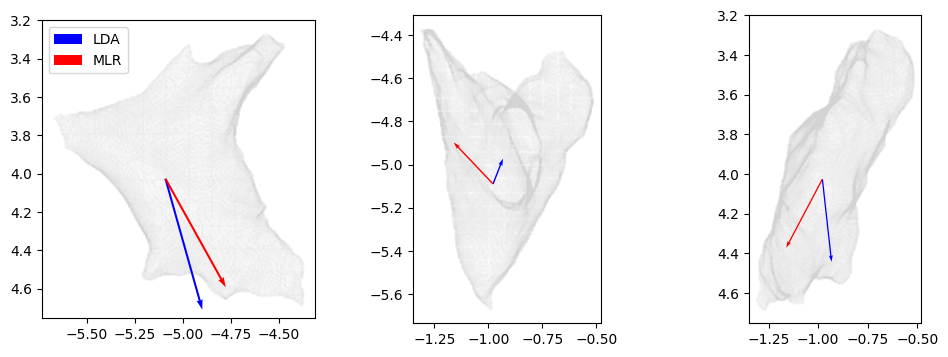

In [248]:
# plot the two axis in 2D ccf space
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
    # sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color='r', alpha=0.2, s=1, edgecolor='none', label=tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], -primary_axis_vector_LDA[planes_mesh[plane][1]],scale=2, color='blue', label='LDA')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_LDA[planes_mesh[plane][0]], primary_axis_vector_LDA[planes_mesh[plane][1]],scale=2, color='blue', label='LDA')
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    ax.set_aspect(aspect='equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    # ax.set_title(plane)
    if plane == 'sag':
        ax.legend()

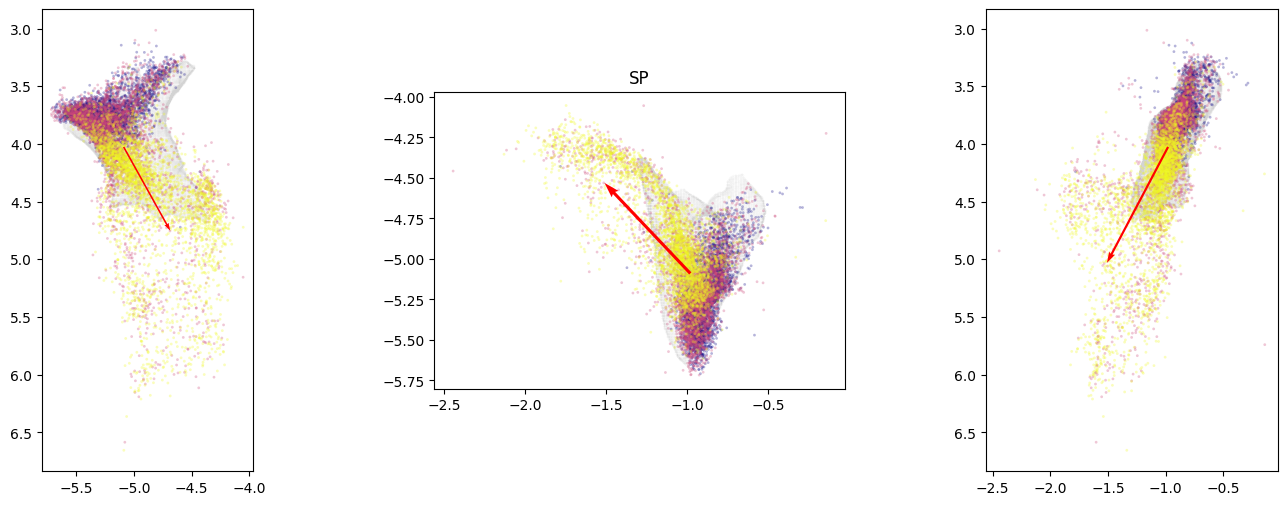

In [249]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

category_order = ['CTX', 'CB', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [category_to_index[cat] / (len(category_order) - 1) for cat in category_order]
colors = [plasma(val) for val in norm_indices]

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.02)
    for ind, tar in enumerate(retro_ccf['injection_region'].unique()):
        mask = (retro_ccf['injection_region'] == tar)
        if tar == 'TH':
            continue
        sc = ax.scatter(ccf_neurons_mm[mask, planes_mesh[plane][0]], ccf_neurons_mm[mask, planes_mesh[plane][1]], color=colors[category_order.index(tar)], alpha=0.3, s=4, edgecolor='none', label=tar)
        ax.set_aspect(aspect='equal')
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        if plane == 'hor':
            ax.set_title(tar)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='red', label='MLR')
    # ax.set_title(plane)

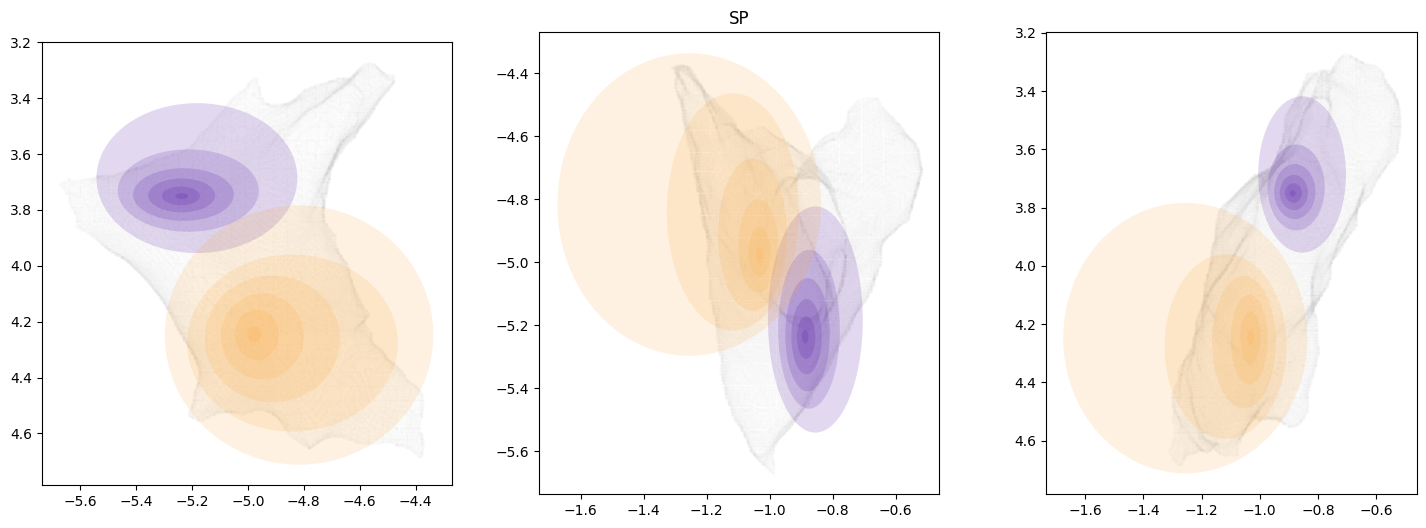

In [292]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex
from matplotlib.patches import Ellipse

category_order = ['CTX', 'SP']
category_to_index = {cat: i for i, cat in enumerate(category_order)}

# Normalize indices to [0, 1] for colormap
norm_indices = [0.1, 0.8]
colors = [plasma(val) for val in norm_indices]
ccf_neurons_mm_center_mask = ccf_neurons_mm[:, dv]<=4.8
centers =[np.mean(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], axis=0) for tar in category_order]
centers = np.array(centers)
bin_count = 12
pers = np.linspace(5, 95, bin_count)
sds = [np.percentile(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], pers, axis=0) for tar in category_order]
sds = np.array(sds)

for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    for ind, tar in enumerate(category_order):
        for ind_per in range(int(0.5*bin_count)):
            inds = np.array([ind_per, bin_count-1-ind_per])
            center = np.mean(sds[ind, inds, planes_mesh[plane][0]]), np.mean(sds[ind, inds, planes_mesh[plane][1]])
            width = (sds[ind, bin_count-1-ind_per, planes_mesh[plane][0]] - sds[ind, ind_per, planes_mesh[plane][0]])
            height = (sds[ind, bin_count-1-ind_per, planes_mesh[plane][1]] - sds[ind, ind_per, planes_mesh[plane][1]])
            ellipse = Ellipse(xy=center, width=width, height=height,
                    edgecolor='none', facecolor=colors[ind], lw=2, alpha=0.15, label=tar)
            ax.add_patch(ellipse)
    ax.set_aspect(aspect='equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'hor':
        ax.set_title(tar)
    # if planes[plane][1] == dv:
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], -primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='b', label='MLR')
    # else:
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_vector_MLR[planes_mesh[plane][0]], primary_axis_vector_MLR[planes_mesh[plane][1]],scale=2, color='b', label='MLR')
    # # ax.set_title(plane)
plt.savefig(os.path.join('/root/capsule/scratch/combined/ccf_maps', 'CTX_SP_2d_projection_no_arrow.pdf'), dpi=300, bbox_inches='tight')


In [276]:
sds = [np.percentile(ccf_neurons_mm[(retro_ccf['injection_region'] == tar) & (ccf_neurons_mm_center_mask)], [10, 30, 50, 70, 90], axis=0) for tar in category_order]


In [285]:
ind_per, bin_count-1-ind_per

(3, 4)

In [284]:
pers

array([ 5.        , 17.85714286, 30.71428571, 43.57142857, 56.42857143,
       69.28571429, 82.14285714, 95.        ])